In [ ]:
!pip install segmentation_models

In [2]:
import tensorflow as tf
#import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split
import albumentations as A
import glob

In [3]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Dropout, Conv2DTranspose, Multiply, ReLU, Add, GlobalAveragePooling2D ,  Reshape, GlobalMaxPooling2D,Permute
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models , layers
from keras.initializers import RandomNormal
from keras import backend as K
from tensorflow.keras.optimizers import Adam

In [4]:
from random import randint

In [26]:
def conv1b(inp,f):
    q = Conv2D(f, 1,(1,1),'valid', use_bias = False)(inp)
    return q

In [5]:
def conv3b(inp,f):
    e = Conv2D(f,3,(1,1),"same",use_bias = False)(inp)
    return e 

In [6]:
def resblock(inp,f):
    inp = Conv2D(f,1, use_bias = False)(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 3, strides=(1,1), padding ='same', use_bias = False , dilation_rate=(2, 2))(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 1, use_bias = False)(inp)
    inp = Activation("LeakyReLU")(inp)
    return inp

In [7]:
def irnn(inp):
    _,H,W,_ = tf.shape(inp)
    tleft = tf.identity(inp)
    tright = tf.identity(inp)
    tup = tf.identity(inp)
    tdown = tf.identity(inp)
    lw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    rw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)   
    uw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    dw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    tleftlist = []
    trightlist = []
    tuplist = []
    tdownlist = []
    tleftlist.append(tf.math.add(lw[:,:,:W,:], inp[:,:,:,:1]))
    tleft = tf.stack(tleftlist)
    tleft = tf.squeeze(tleft, axis = 0)
    trightlist.append(tf.math.add(rw[:,:,0:,:], inp[:,:,:W,:1]))
    tright = tf.stack(trightlist)
    tright = tf.squeeze(tright, axis = 0)
    tuplist.append(tf.math.add(uw[:,:H,:,:], inp[:,0:,:,:1]))
    tup = tf.stack(tuplist)
    tup = tf.squeeze(tup, axis = 0)
    tdownlist.append(tf.math.add(uw[:,0:,:,:], inp[:,:H,:,:1]))
    tdown = tf.stack(tdownlist)
    tdown = tf.squeeze(tdown, axis = 0)
    tleft = Activation("LeakyReLU")(tleft)
    tright = Activation("LeakyReLU")(tright)
    tup = Activation("LeakyReLU")(tup)
    tdown = Activation("LeakyReLU")(tdown)
    return tleft, tright, tup, tdown


In [8]:
def attention(x,f):
    inp = Conv2D(f, 3,(1,1),'same')(x)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 3,(1,1),'same')(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 1,(1,1),'valid')(inp)
    inp = Activation("LeakyReLU")(inp)
    return inp

In [9]:
def channel_attention(x):
    channel = x
    layer_one = Conv2D(32,1, activation='relu' )
    
    xap = GlobalAveragePooling2D(keepdims=True)(x)
    xap = layer_one(xap)
    
    xmp = GlobalMaxPooling2D(keepdims=True)(x)
    xmp = layer_one(xmp)
    
    x = xap + xmp
    x = tf.keras.activations.sigmoid(x)
    
    return(x)

In [29]:
#def channel_attention(x):
    #channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    #channel = x.shape[channel_axis]
    #print(x)
    #print(channel)
    
    #layer_one = Conv2D(32,1, activation='relu',kernel_initializer='glorot_uniform',use_bias=True, bias_initializer='zeros' )
    #layer_two = Conv2D(32,1, kernel_initializer='glorot_uniform',use_bias=True, bias_initializer='zeros' )
    #avg_pool = GlobalAveragePooling2D()(x)
    #avg_pool = Reshape((1,1,channel))(avg_pool)
    
    #assert avg_pool.shape[1:] == (1,1,channel)
    #avg_pool = layer_one(avg_pool)
    #assert avg_pool.shape[1:] == (1,1,channel//8)
    #avg_pool = layer_two(avg_pool)
    #assert avg_pool.shape[1:] == (1,1,channel)
    #max_pool = GlobalMaxPooling2D()(x)
    #max_pool = Reshape((1,1,channel))(max_pool)
    #assert max_pool.shape[1:] == (1,1,channel)
    #max_pool = layer_one(max_pool)
    #assert max_pool.shape[1:] == (1,1,channel//8)
    #max_pool = layer_two(max_pool)
    #assert max_pool.shape[1:] == (1,1,channel)
    #feature = Add()([avg_pool,max_pool])
    #feature = Activation('sigmoid')(feature)
    #feature = Permute((3, 1, 2))(feature)
    #print(feature)
    #print(channel)
    #return Multiply()([channel, feature])


In [10]:
def SAM (x,f):
    attention_layer = attention(x,f)
    x = Conv2D(f,1,(1,1),'valid')(x)
    tleft, tright, tup, tdown = irnn(x)
    if attention:
        x1 = Multiply()([tup,attention_layer[:,:,:,0:1]])
        x2 = Multiply()([tright,attention_layer[:,:,:,1:2]])
        x3 = Multiply()([tdown,attention_layer[:,:,:,2:3]])
        x4 = Multiply()([tleft,attention_layer[:,:,:,3:4]])
    x = Concatenate()([x1,x2,x3,x4])
    x = Conv2D(f*4,1,(1,1),'valid')(x)
    x = irnn(x)
    if attention:
        x1 = Multiply()([tup,attention_layer[:,:,:,0:1]])
        x2 = Multiply()([tright,attention_layer[:,:,:,1:2]])
        x3 = Multiply()([tdown,attention_layer[:,:,:,2:3]])
        x4 = Multiply()([tleft,attention_layer[:,:,:,3:4]])
    x = Concatenate()([x1,x2,x3,x4])
    x = Conv2D(f*4,1,(1,1), 'valid')(x)
    x = Activation('LeakyReLU')(x)
    x = tf.keras.activations.sigmoid(conv1b(x,32))
    return x

In [11]:
def Spa_gen(image_shape):
    in_image = tf.keras.Input(image_shape, 1)
    
    x = conv3b(in_image,32)
    
    
    x = Activation("LeakyReLU")(x)
    
    res_block1= resblock(x,32)
    
    x = Activation('LeakyReLU')(res_block1+x)
    res_block2= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block2+x)
    
    
    res_block3= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block3+x)
    
    x = tf.keras.layers.LeakyReLU()(channel_attention(x)+x)
    
    #print(tf.shape(x))
    attention1 = SAM(x,32) 
    
    res_block4= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block4*attention1+x)  
    res_block5= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block5*attention1+x)
    res_block6= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block6*attention1+x)
    
    attention2 = SAM(x,32)
    res_block7= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block7*attention2+x)
    res_block8= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block8*attention2+x)
    res_block9= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block9*attention2+x)
    attention3 = SAM(x,32)
    
    res_block10= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block10*attention3+x)
    
    res_block11= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block11*attention3+x)
    
    res_block12= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block1*attention3+x)
    
    attention4 = SAM(x,32)

    res_block13= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block13*attention4+x)
    
    res_block14= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block14*attention4+x)
    
    res_block15= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block15*attention4+x)
    
    res_block16= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block16+x)
    
    res_block17= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block17+x)
    x = Conv2D(3,3,(1,1),'same', use_bias = False)(x)
    
    
    return Model(in_image, x)

In [12]:
def discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    source_image = Input(shape=image_shape)
    gen_image = Input(shape=image_shape) #image produced from generator
    join = Concatenate()([source_image,gen_image]) #concatenate images channel-wise
    # Block 1: input is 512 x 512 x (3)
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=init, name='conv_1')(join)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    # Block 2: input is 256 x 256 x (64)
    x = layers.Conv2D(128, 4, 2, 'same', kernel_initializer=init, name='conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    # Block 3: input is 64 x 64 x (128)
    x = layers.Conv2D(256, 4, 2, 'same', kernel_initializer=init, name='conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
    # Block 4: input is 32 x 32 x (256)
    x = layers.Conv2D(512, 4, 2, 'same', kernel_initializer=init, name='conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    # Block 5: input is 16 x 16 x (512)
    outputs = layers.Conv2D(1, 4, 2, 'same', kernel_initializer=init, activation='sigmoid', name='conv_5')(x)
    # Output: 1 x 1 x 1
    #define model
    model = Model([source_image,gen_image], outputs)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [13]:
def call_GAN(g_model, d_model, image_shape):
    d_model.trainable = False
    sourc_image = Input(shape=image_shape) 
    gen_out = g_model(sourc_image)
    print(gen_out)
    dis_out = d_model([sourc_image, gen_out])
    model = Model(sourc_image, [dis_out, gen_out])
    opt = Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [14]:
trainlistpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/train_list.txt'
trainlistn = os.path.join(trainlistpath)
trainlistlnk = open(trainlistpath)
trainlist = trainlistlnk.read()
trainlist = trainlist.split('\n')
del trainlist[-1]

In [ ]:
len(trainlist)

In [15]:
testlistpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/test_list.txt'
testlistn = os.path.join(testlistpath)
testlistlnk = open(testlistn)
testlist = testlistlnk.read()
testlist = testlist.split("\n")
del testlist[-1]

(512, 512, 3)


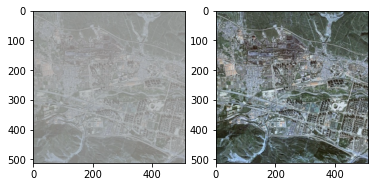

In [16]:
cloudypath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/cloudy_image/'
groundtruthpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/ground_truth'
traincloud = [os.path.join(cloudypath,x) for x in trainlist]
traingroundtruth = [os.path.join(groundtruthpath,x) for x in trainlist]
pic = cv2.imread(traincloud[13])
pic1 = cv2.imread(traingroundtruth[13])
image_shape = pic1.shape
print(image_shape)
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(pic1)

In [17]:
def datapreprocesstest(c,g):
    #tc = []
    #tg = []
    fc = glob.glob(c)
    fg = glob.glob(g)
    #for f1 in fc:
    Im =cv2.imread(str(c)).astype(np.float32)
    Im = Im[np.newaxis, :, :, :]
        #tc.append(Im)
    #for f2 in fg:
    Ig = cv2.imread(str(g)).astype(np.float32)
    Ig = Ig[np.newaxis, :, :, :]
        #tg.append(Ig)    
    Imm = Im/255
    Igg = Ig/255
    #tc = Imm.transpose(2,0,1)
    #tg = Igg.transpose(2,0,1)
    
    return Imm, Igg

In [18]:
batchsize = 1
tg = []
tm = []
for i in range(400):
    
    dataset = datapreprocesstest(traincloud[i], traingroundtruth[i])
    tg.append(dataset[0])
    tm.append(dataset[1])

In [ ]:
len(tm)

In [19]:
def tf_dataset(traincloud, traingroundtruth,x):
    BUFFER_SIZE = 5000
    BATCH_SIZE = x
    print(tf.rank(traincloud))

# Batch and shuffle the data
    traincloud = tf.data.Dataset.from_tensor_slices(traincloud)
    print(traincloud)
    traingroundtruth = tf.data.Dataset.from_tensor_slices(traingroundtruth)
    print(traingroundtruth)
    #datasets = datasets.shuffle(buffer_size=400).batch(batch_size =1)

    return traincloud, traingroundtruth

In [ ]:
dataset = tf_dataset(tg[0:1], tm[0:1], 1)

In [ ]:
len(dataset[0])

In [ ]:
#tr = tf.data.Dataset.from_tensors(pic)
#tf.shape(tr)

In [ ]:
#img = img[np.newaxis, :,  :, :]

In [ ]:
#pic1 = pic[np.newaxis, :, :, :]
#pic1.shape

In [20]:
def generate_real_samples(dataset, n_samples, patch_shape):
    global X1
    global X2
    #X1 =0
    #X2 = 0
    trainA, trainB = dataset
    l = len(trainA)
    ix = randint(0, l)
    c = 0
    for i in trainA:
        if c == ix:
            X1 = i
        else:
            c+=1
    h =0
    for j in trainB:
        if h == ix:
            X2 = j
        else:
            h+=1
    
    
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [21]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [22]:
def summarize_performance(step, g_model, dataset, n_samples=3): 
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    print(len(X_realA))
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    print(len(X_realA))
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    for i in range(1):
        plt.subplot(1, n_samples, 1)
        plt.axis('off')
        plt.imshow(X_realA[i])
        plt.show()
    
    for i in range(1):
        plt.subplot(1, n_samples, 2)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        plt.show()
        
    for i in range(1):
        plt.subplot(1, n_samples, 3)
        plt.axis('off')
        plt.imshow(X_realB[i])
        plt.show()

    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
  
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [43]:
def train(d_model, g_model, gan_model, dataset, n_epochs=500, n_batch=1):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    #bat_per_epo = int(len(trainA) / n_batch)
    #n_steps = bat_per_epo * n_epochs
    n_steps = 1500
    d_loss1_log = []
    d_loss2_log = []
    g_loss_log = []
    SSIM_log = []
    mse_log = []
    psnr_log = []
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss1_log.append(d_loss1)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss2_log.append(d_loss2)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        g_loss_log.append(g_loss)
        ssim = tf.image.ssim(X_realB, X_fakeB, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
        SSIM_log.append(ssim)
        loss = tf.keras.losses.mean_squared_error(X_realB, X_fakeB)
        l =tf.math.reduce_mean(loss, axis=None, keepdims=False, name=None)
        mse_log.append(l)
        psnr = tf.image.psnr(X_realB, X_fakeB, max_val=1.0)
        psnr_log.append(psnr)
        
        avgssim = sum(SSIM_log)/len(SSIM_log)
        avgmse = sum(mse_log)/len(mse_log)
        avgpsnr = sum(psnr_log)/len(psnr_log)
        

        plt.clf()
        plt.figure(figsize=(20,12))
        plt.title('Epoch:%d, d1[%.3f] d2[%.3f] g[%.3f] ssim[%.3f] mse[%.3f] psnr[%.3f] avgssim[%.3f] avgmse[%.3f] avgpsnr[%.3f] ' % (i+1, d_loss1, d_loss2, g_loss, ssim, l, psnr, avgssim, avgmse, avgpsnr))
        plt.xlabel('Epoch', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        
        plt.plot(d_loss1_log, 'r-', lw=2, label='d_loss1')
        plt.plot(d_loss2_log, 'b-', lw=1, label='d_loss2')
        plt.plot(g_loss_log, 'g-', lw=1, label='g_loss')
        #plt.plot(SSIM_log,'c-', lw =1, label='ssim' )
        #plt.plot(mse_log, 'k-', lw =1, label ='mse')
        plt.plot(psnr_log, 'm-', lw = 1, label = 'psnr')
        
        plt.ylim((0,100))
        
       # avgssim = sum(ssim_log)/len(ssim_log)
       # avgmse = sum(mse_log)/len(mse_log)
       # avgpsnr = sum(psnr_log)/len(psnr_log)
        
        
        plt.legend(prop={'size':16}, loc="upper right")
        #plt.show()
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] ssim[%.3f] mse[%.3f] psnr[%.3f] avgssim[%.3f] avgmse[%.3f] avgpsnr[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, ssim, l, psnr,avgssim, avgmse, avgpsnr))
        if (i+1) % 50 == 0:
            plt.savefig('./loss_graph_%06d.jpg' % (i+1), bbox_inches='tight')
            summarize_performance(i, g_model, dataset)

In [ ]:
 ssim2 = tf.image.ssim(aa, hh, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

In [24]:
image_shape = (512,512,3)

In [27]:
g_model = Spa_gen(image_shape)

In [28]:
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (1, 512, 512, 32)    864         input_2[0][0]                    
__________________________________________________________________________________________________
activation_23 (Activation)      (1, 512, 512, 32)    0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (1, 512, 512, 32)    1024        activation_23[0][0]              
______________________________________________________________________________________________

tf.Tensor(5, shape=(), dtype=int32)
<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>
<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>
Dataset loaded
(<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>, <TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>)
KerasTensor(type_spec=TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name=None), name='model_5/conv2d_366/Conv2D:0', description="created by layer 'model_5'")
>1, d1[0.408] d2[0.580] g[84.469] ssim[0.048] mse[1.109] psnr[-0.449] avgssim[0.048] avgmse[1.109] avgpsnr[-0.449]
>2, d1[0.132] d2[0.100] g[77.603] ssim[0.039] mse[0.940] psnr[0.271] avgssim[0.043] avgmse[1.024] avgpsnr[-0.089]
>3, d1[0.087] d2[0.026] g[70.748] ssim[0.027] mse[0.786] psnr[1.044] avgssim[0.038] avgmse[0.945] avgpsnr[0.289]
>4, d1[0.042] d2[0.015] g[64.015] ssim[0.017] mse[0.651] psnr[1.865] avgssim[0.033] avgmse[0.871] avgpsnr[0.683]
>5, d1[0.037] d2[0.013] g[57.387] ssim[0.014] mse[0.532] psnr[2.73

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


>20, d1[0.003] d2[0.002] g[10.863] ssim[0.284] mse[0.027] psnr[15.693] avgssim[0.152] avgmse[0.291] avgpsnr[8.903]
>21, d1[0.003] d2[0.002] g[10.843] ssim[0.285] mse[0.027] psnr[15.641] avgssim[0.158] avgmse[0.278] avgpsnr[9.224]
>22, d1[0.003] d2[0.002] g[10.850] ssim[0.286] mse[0.027] psnr[15.614] avgssim[0.164] avgmse[0.267] avgpsnr[9.514]
>23, d1[0.002] d2[0.002] g[10.859] ssim[0.287] mse[0.027] psnr[15.631] avgssim[0.169] avgmse[0.256] avgpsnr[9.780]
>24, d1[0.002] d2[0.002] g[10.868] ssim[0.289] mse[0.027] psnr[15.650] avgssim[0.174] avgmse[0.247] avgpsnr[10.025]
>25, d1[0.002] d2[0.001] g[10.873] ssim[0.290] mse[0.027] psnr[15.659] avgssim[0.179] avgmse[0.238] avgpsnr[10.250]
>26, d1[0.002] d2[0.001] g[10.879] ssim[0.292] mse[0.027] psnr[15.672] avgssim[0.183] avgmse[0.230] avgpsnr[10.459]
>27, d1[0.002] d2[0.001] g[10.886] ssim[0.293] mse[0.027] psnr[15.693] avgssim[0.187] avgmse[0.222] avgpsnr[10.652]
>28, d1[0.002] d2[0.001] g[10.894] ssim[0.294] mse[0.027] psnr[15.708] avgss

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

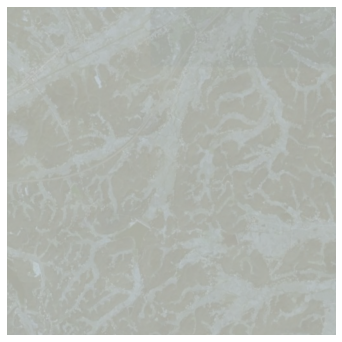

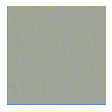

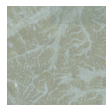

>Saved: plot_000050.png and model_000050.h5
>51, d1[0.001] d2[0.001] g[11.129] ssim[0.321] mse[0.025] psnr[15.955] avgssim[0.244] avgmse[0.130] avgpsnr[13.081]
>52, d1[0.001] d2[0.001] g[11.135] ssim[0.322] mse[0.025] psnr[15.966] avgssim[0.245] avgmse[0.128] avgpsnr[13.137]
>53, d1[0.001] d2[0.001] g[11.145] ssim[0.324] mse[0.025] psnr[15.974] avgssim[0.247] avgmse[0.126] avgpsnr[13.190]
>54, d1[0.001] d2[0.001] g[11.156] ssim[0.325] mse[0.025] psnr[15.985] avgssim[0.248] avgmse[0.124] avgpsnr[13.242]
>55, d1[0.001] d2[0.001] g[11.166] ssim[0.326] mse[0.025] psnr[15.995] avgssim[0.250] avgmse[0.122] avgpsnr[13.292]
>56, d1[0.001] d2[0.001] g[11.175] ssim[0.328] mse[0.025] psnr[16.007] avgssim[0.251] avgmse[0.121] avgpsnr[13.340]
>57, d1[0.001] d2[0.001] g[11.182] ssim[0.329] mse[0.025] psnr[16.020] avgssim[0.252] avgmse[0.119] avgpsnr[13.387]
>58, d1[0.001] d2[0.000] g[11.189] ssim[0.331] mse[0.025] psnr[16.033] avgssim[0.254] avgmse[0.117] avgpsnr[13.433]
>59, d1[0.001] d2[0.000] g[1

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

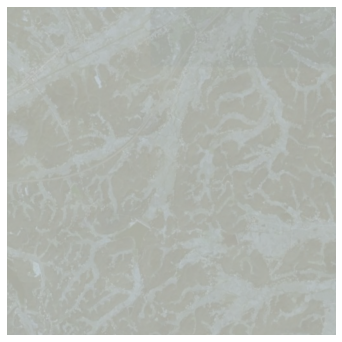

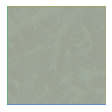

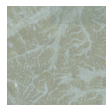

>Saved: plot_000100.png and model_000100.h5
>101, d1[0.000] d2[0.000] g[11.388] ssim[0.400] mse[0.022] psnr[16.524] avgssim[0.301] avgmse[0.077] avgpsnr[14.639]
>102, d1[0.000] d2[0.000] g[11.390] ssim[0.402] mse[0.022] psnr[16.596] avgssim[0.302] avgmse[0.077] avgpsnr[14.658]
>103, d1[0.000] d2[0.000] g[11.395] ssim[0.404] mse[0.022] psnr[16.523] avgssim[0.303] avgmse[0.076] avgpsnr[14.677]
>104, d1[0.000] d2[0.000] g[11.419] ssim[0.405] mse[0.022] psnr[16.647] avgssim[0.304] avgmse[0.076] avgpsnr[14.695]
>105, d1[0.000] d2[0.000] g[11.450] ssim[0.408] mse[0.023] psnr[16.477] avgssim[0.305] avgmse[0.075] avgpsnr[14.712]
>106, d1[0.000] d2[0.000] g[11.600] ssim[0.408] mse[0.021] psnr[16.682] avgssim[0.306] avgmse[0.075] avgpsnr[14.731]
>107, d1[0.000] d2[0.000] g[11.654] ssim[0.410] mse[0.023] psnr[16.348] avgssim[0.307] avgmse[0.074] avgpsnr[14.746]
>108, d1[0.000] d2[0.000] g[12.175] ssim[0.407] mse[0.022] psnr[16.552] avgssim[0.308] avgmse[0.074] avgpsnr[14.763]
>109, d1[0.000] d2[0

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

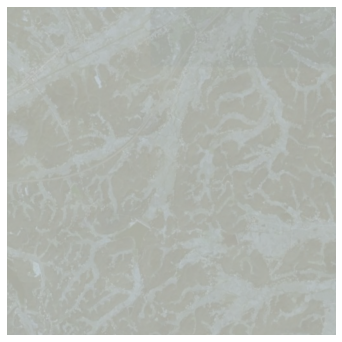

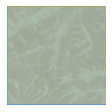

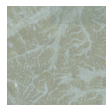

>Saved: plot_000150.png and model_000150.h5
>151, d1[0.000] d2[0.000] g[12.242] ssim[0.475] mse[0.020] psnr[16.975] avgssim[0.347] avgmse[0.059] avgpsnr[15.338]
>152, d1[0.000] d2[0.000] g[11.832] ssim[0.480] mse[0.021] psnr[16.744] avgssim[0.348] avgmse[0.059] avgpsnr[15.347]
>153, d1[0.000] d2[0.000] g[12.196] ssim[0.478] mse[0.020] psnr[17.015] avgssim[0.349] avgmse[0.058] avgpsnr[15.358]
>154, d1[0.000] d2[0.000] g[11.588] ssim[0.484] mse[0.021] psnr[16.866] avgssim[0.350] avgmse[0.058] avgpsnr[15.368]
>155, d1[0.000] d2[0.000] g[11.713] ssim[0.484] mse[0.019] psnr[17.184] avgssim[0.351] avgmse[0.058] avgpsnr[15.379]
>156, d1[0.000] d2[0.000] g[11.414] ssim[0.488] mse[0.020] psnr[16.958] avgssim[0.352] avgmse[0.058] avgpsnr[15.390]
>157, d1[0.000] d2[0.000] g[11.580] ssim[0.488] mse[0.019] psnr[17.235] avgssim[0.353] avgmse[0.057] avgpsnr[15.401]
>158, d1[0.000] d2[0.000] g[11.410] ssim[0.491] mse[0.020] psnr[16.976] avgssim[0.354] avgmse[0.057] avgpsnr[15.411]
>159, d1[0.000] d2[0

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

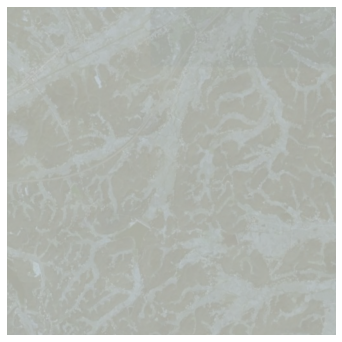

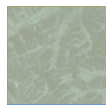

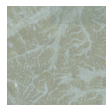

>Saved: plot_000200.png and model_000200.h5
>201, d1[0.000] d2[0.000] g[11.350] ssim[0.552] mse[0.017] psnr[17.598] avgssim[0.390] avgmse[0.049] avgpsnr[15.812]
>202, d1[0.000] d2[0.000] g[11.236] ssim[0.550] mse[0.019] psnr[17.287] avgssim[0.390] avgmse[0.049] avgpsnr[15.820]
>203, d1[0.000] d2[0.000] g[11.529] ssim[0.554] mse[0.018] psnr[17.558] avgssim[0.391] avgmse[0.049] avgpsnr[15.828]
>204, d1[0.000] d2[0.000] g[11.312] ssim[0.552] mse[0.019] psnr[17.265] avgssim[0.392] avgmse[0.048] avgpsnr[15.835]
>205, d1[0.000] d2[0.000] g[11.488] ssim[0.557] mse[0.017] psnr[17.578] avgssim[0.393] avgmse[0.048] avgpsnr[15.844]
>206, d1[0.000] d2[0.000] g[11.181] ssim[0.554] mse[0.019] psnr[17.324] avgssim[0.394] avgmse[0.048] avgpsnr[15.851]
>207, d1[0.000] d2[0.000] g[11.315] ssim[0.560] mse[0.017] psnr[17.635] avgssim[0.394] avgmse[0.048] avgpsnr[15.860]
>208, d1[0.000] d2[0.000] g[11.152] ssim[0.557] mse[0.018] psnr[17.349] avgssim[0.395] avgmse[0.048] avgpsnr[15.867]
>209, d1[0.000] d2[0

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

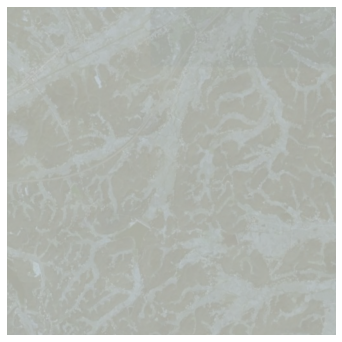

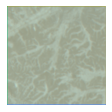

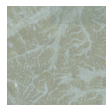

>Saved: plot_000250.png and model_000250.h5
>251, d1[0.000] d2[0.000] g[10.881] ssim[0.602] mse[0.016] psnr[17.867] avgssim[0.426] avgmse[0.043] avgpsnr[16.165]
>252, d1[0.000] d2[0.000] g[10.850] ssim[0.589] mse[0.017] psnr[17.614] avgssim[0.427] avgmse[0.043] avgpsnr[16.171]
>253, d1[0.000] d2[0.000] g[10.870] ssim[0.604] mse[0.016] psnr[17.873] avgssim[0.428] avgmse[0.042] avgpsnr[16.177]
>254, d1[0.000] d2[0.000] g[10.840] ssim[0.590] mse[0.017] psnr[17.625] avgssim[0.428] avgmse[0.042] avgpsnr[16.183]
>255, d1[0.000] d2[0.000] g[10.848] ssim[0.606] mse[0.016] psnr[17.877] avgssim[0.429] avgmse[0.042] avgpsnr[16.190]
>256, d1[0.000] d2[0.000] g[10.791] ssim[0.591] mse[0.017] psnr[17.646] avgssim[0.430] avgmse[0.042] avgpsnr[16.195]
>257, d1[0.000] d2[0.000] g[10.781] ssim[0.608] mse[0.016] psnr[17.894] avgssim[0.430] avgmse[0.042] avgpsnr[16.202]
>258, d1[0.000] d2[0.000] g[10.749] ssim[0.594] mse[0.017] psnr[17.683] avgssim[0.431] avgmse[0.042] avgpsnr[16.208]
>259, d1[0.000] d2[0

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

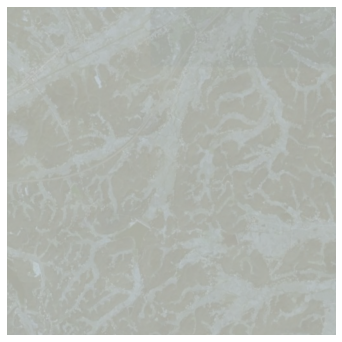

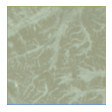

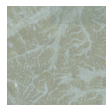

>Saved: plot_000300.png and model_000300.h5
>301, d1[0.000] d2[0.000] g[10.055] ssim[0.617] mse[0.017] psnr[17.734] avgssim[0.458] avgmse[0.038] avgpsnr[16.447]
>302, d1[0.000] d2[0.000] g[10.030] ssim[0.604] mse[0.017] psnr[17.656] avgssim[0.458] avgmse[0.038] avgpsnr[16.451]
>303, d1[0.000] d2[0.000] g[10.017] ssim[0.596] mse[0.018] psnr[17.539] avgssim[0.459] avgmse[0.038] avgpsnr[16.454]
>304, d1[0.000] d2[0.000] g[10.001] ssim[0.579] mse[0.018] psnr[17.389] avgssim[0.459] avgmse[0.038] avgpsnr[16.457]
>305, d1[0.000] d2[0.000] g[9.989] ssim[0.555] mse[0.019] psnr[17.172] avgssim[0.459] avgmse[0.038] avgpsnr[16.460]
>306, d1[0.000] d2[0.000] g[10.001] ssim[0.535] mse[0.020] psnr[16.985] avgssim[0.460] avgmse[0.038] avgpsnr[16.461]
>307, d1[0.000] d2[0.000] g[10.024] ssim[0.527] mse[0.020] psnr[16.925] avgssim[0.460] avgmse[0.038] avgpsnr[16.463]
>308, d1[0.000] d2[0.000] g[10.049] ssim[0.531] mse[0.020] psnr[16.942] avgssim[0.460] avgmse[0.038] avgpsnr[16.464]
>309, d1[0.000] d2[0.

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

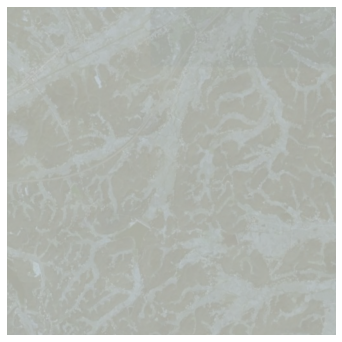

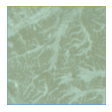

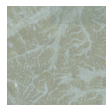

>Saved: plot_000350.png and model_000350.h5
>351, d1[0.000] d2[0.000] g[10.030] ssim[0.678] mse[0.016] psnr[17.875] avgssim[0.471] avgmse[0.036] avgpsnr[16.532]
>352, d1[0.000] d2[0.000] g[9.417] ssim[0.664] mse[0.018] psnr[17.423] avgssim[0.472] avgmse[0.036] avgpsnr[16.535]
>353, d1[0.000] d2[0.000] g[10.413] ssim[0.656] mse[0.021] psnr[16.848] avgssim[0.473] avgmse[0.036] avgpsnr[16.536]
>354, d1[0.000] d2[0.000] g[9.637] ssim[0.641] mse[0.019] psnr[17.215] avgssim[0.473] avgmse[0.036] avgpsnr[16.538]
>355, d1[0.000] d2[0.000] g[9.474] ssim[0.642] mse[0.020] psnr[17.089] avgssim[0.473] avgmse[0.035] avgpsnr[16.539]
>356, d1[0.000] d2[0.000] g[9.828] ssim[0.643] mse[0.019] psnr[17.215] avgssim[0.474] avgmse[0.035] avgpsnr[16.541]
>357, d1[0.000] d2[0.000] g[10.241] ssim[0.658] mse[0.019] psnr[17.192] avgssim[0.474] avgmse[0.035] avgpsnr[16.543]
>358, d1[0.000] d2[0.000] g[9.630] ssim[0.652] mse[0.020] psnr[17.044] avgssim[0.475] avgmse[0.035] avgpsnr[16.544]
>359, d1[0.000] d2[0.000]

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

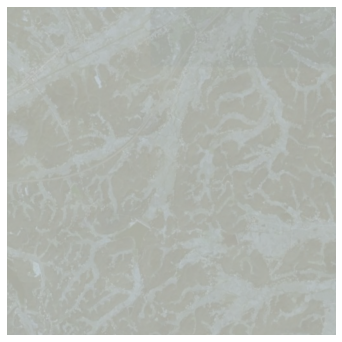

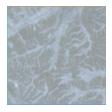

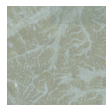

>Saved: plot_000400.png and model_000400.h5
>401, d1[0.000] d2[0.000] g[9.684] ssim[0.666] mse[0.022] psnr[16.531] avgssim[0.495] avgmse[0.034] avgpsnr[16.592]
>402, d1[0.000] d2[0.000] g[10.162] ssim[0.678] mse[0.018] psnr[17.476] avgssim[0.496] avgmse[0.034] avgpsnr[16.594]
>403, d1[0.000] d2[0.000] g[10.747] ssim[0.652] mse[0.028] psnr[15.537] avgssim[0.496] avgmse[0.034] avgpsnr[16.591]
>404, d1[0.000] d2[0.000] g[11.363] ssim[0.674] mse[0.018] psnr[17.471] avgssim[0.497] avgmse[0.034] avgpsnr[16.594]
>405, d1[0.000] d2[0.000] g[9.550] ssim[0.671] mse[0.021] psnr[16.868] avgssim[0.497] avgmse[0.034] avgpsnr[16.594]
>406, d1[0.000] d2[0.000] g[10.323] ssim[0.659] mse[0.025] psnr[15.997] avgssim[0.497] avgmse[0.034] avgpsnr[16.593]
>407, d1[0.000] d2[0.000] g[11.976] ssim[0.676] mse[0.017] psnr[17.577] avgssim[0.498] avgmse[0.034] avgpsnr[16.595]
>408, d1[0.000] d2[0.000] g[9.889] ssim[0.681] mse[0.018] psnr[17.475] avgssim[0.498] avgmse[0.033] avgpsnr[16.597]
>409, d1[0.000] d2[0.00

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

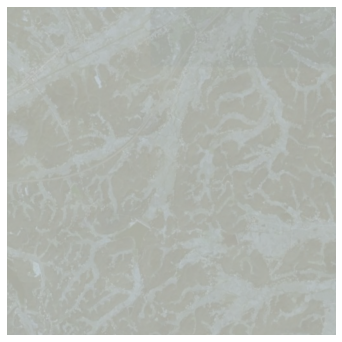

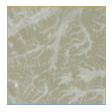

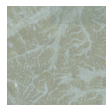

>Saved: plot_000450.png and model_000450.h5
>451, d1[0.000] d2[0.000] g[7.593] ssim[0.696] mse[0.016] psnr[18.007] avgssim[0.513] avgmse[0.032] avgpsnr[16.699]
>452, d1[0.000] d2[0.000] g[10.632] ssim[0.674] mse[0.014] psnr[18.510] avgssim[0.514] avgmse[0.032] avgpsnr[16.703]
>453, d1[0.000] d2[0.000] g[9.598] ssim[0.682] mse[0.022] psnr[16.522] avgssim[0.514] avgmse[0.032] avgpsnr[16.703]
>454, d1[0.000] d2[0.000] g[8.007] ssim[0.674] mse[0.018] psnr[17.490] avgssim[0.514] avgmse[0.032] avgpsnr[16.705]
>455, d1[0.000] d2[0.000] g[9.496] ssim[0.700] mse[0.014] psnr[18.651] avgssim[0.515] avgmse[0.032] avgpsnr[16.709]
>456, d1[0.000] d2[0.000] g[9.341] ssim[0.688] mse[0.021] psnr[16.681] avgssim[0.515] avgmse[0.032] avgpsnr[16.709]
>457, d1[0.000] d2[0.000] g[8.235] ssim[0.628] mse[0.017] psnr[17.600] avgssim[0.516] avgmse[0.032] avgpsnr[16.711]
>458, d1[0.000] d2[0.000] g[8.550] ssim[0.692] mse[0.013] psnr[18.727] avgssim[0.516] avgmse[0.032] avgpsnr[16.715]
>459, d1[0.000] d2[0.000] g

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

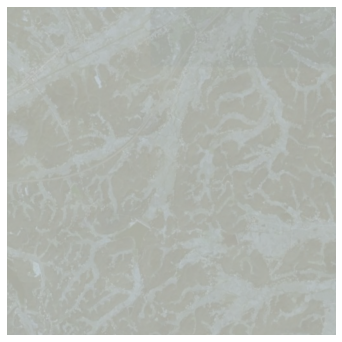

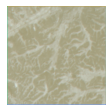

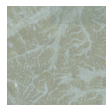

>Saved: plot_000500.png and model_000500.h5
>501, d1[0.000] d2[0.000] g[9.296] ssim[0.638] mse[0.019] psnr[17.276] avgssim[0.529] avgmse[0.031] avgpsnr[16.794]
>502, d1[0.000] d2[0.000] g[8.917] ssim[0.681] mse[0.016] psnr[18.003] avgssim[0.529] avgmse[0.030] avgpsnr[16.796]
>503, d1[0.000] d2[0.000] g[9.930] ssim[0.700] mse[0.023] psnr[16.454] avgssim[0.530] avgmse[0.030] avgpsnr[16.796]
>504, d1[0.000] d2[0.000] g[9.412] ssim[0.636] mse[0.018] psnr[17.542] avgssim[0.530] avgmse[0.030] avgpsnr[16.797]
>505, d1[0.000] d2[0.000] g[8.596] ssim[0.695] mse[0.017] psnr[17.717] avgssim[0.530] avgmse[0.030] avgpsnr[16.799]
>506, d1[0.000] d2[0.000] g[8.848] ssim[0.708] mse[0.015] psnr[18.162] avgssim[0.530] avgmse[0.030] avgpsnr[16.802]
>507, d1[0.000] d2[0.000] g[9.745] ssim[0.655] mse[0.021] psnr[16.813] avgssim[0.531] avgmse[0.030] avgpsnr[16.802]
>508, d1[0.000] d2[0.000] g[8.821] ssim[0.676] mse[0.017] psnr[17.636] avgssim[0.531] avgmse[0.030] avgpsnr[16.803]
>509, d1[0.000] d2[0.000] g[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

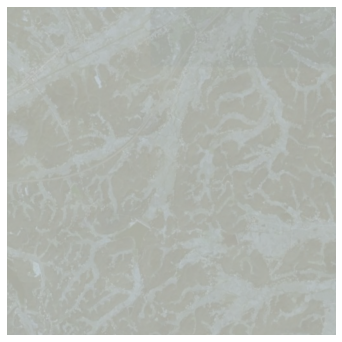

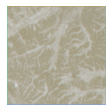

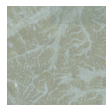

>Saved: plot_000550.png and model_000550.h5
>551, d1[0.000] d2[0.000] g[8.649] ssim[0.709] mse[0.016] psnr[17.899] avgssim[0.543] avgmse[0.029] avgpsnr[16.848]
>552, d1[0.000] d2[0.000] g[8.980] ssim[0.713] mse[0.018] psnr[17.523] avgssim[0.544] avgmse[0.029] avgpsnr[16.849]
>553, d1[0.000] d2[0.000] g[9.455] ssim[0.690] mse[0.015] psnr[18.349] avgssim[0.544] avgmse[0.029] avgpsnr[16.852]
>554, d1[0.000] d2[0.000] g[11.376] ssim[0.663] mse[0.025] psnr[15.976] avgssim[0.544] avgmse[0.029] avgpsnr[16.850]
>555, d1[0.000] d2[0.000] g[9.474] ssim[0.697] mse[0.021] psnr[16.812] avgssim[0.544] avgmse[0.029] avgpsnr[16.850]
>556, d1[0.000] d2[0.000] g[10.756] ssim[0.715] mse[0.015] psnr[18.237] avgssim[0.545] avgmse[0.029] avgpsnr[16.853]
>557, d1[0.000] d2[0.000] g[11.178] ssim[0.699] mse[0.024] psnr[16.181] avgssim[0.545] avgmse[0.029] avgpsnr[16.851]
>558, d1[0.000] d2[0.000] g[9.978] ssim[0.684] mse[0.017] psnr[17.644] avgssim[0.545] avgmse[0.029] avgpsnr[16.853]
>559, d1[0.000] d2[0.000]

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

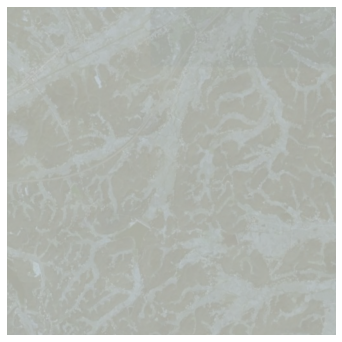

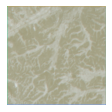

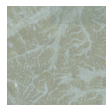

>Saved: plot_000600.png and model_000600.h5
>601, d1[0.000] d2[0.000] g[8.909] ssim[0.715] mse[0.015] psnr[18.117] avgssim[0.555] avgmse[0.029] avgpsnr[16.894]
>602, d1[0.000] d2[0.000] g[8.838] ssim[0.688] mse[0.017] psnr[17.825] avgssim[0.556] avgmse[0.028] avgpsnr[16.896]
>603, d1[0.000] d2[0.000] g[9.190] ssim[0.708] mse[0.015] psnr[18.263] avgssim[0.556] avgmse[0.028] avgpsnr[16.898]
>604, d1[0.000] d2[0.000] g[10.615] ssim[0.707] mse[0.025] psnr[16.086] avgssim[0.556] avgmse[0.028] avgpsnr[16.896]
>605, d1[0.000] d2[0.000] g[9.254] ssim[0.697] mse[0.020] psnr[17.060] avgssim[0.556] avgmse[0.028] avgpsnr[16.897]
>606, d1[0.000] d2[0.000] g[10.100] ssim[0.722] mse[0.015] psnr[18.204] avgssim[0.557] avgmse[0.028] avgpsnr[16.899]
>607, d1[0.000] d2[0.000] g[10.914] ssim[0.713] mse[0.025] psnr[15.962] avgssim[0.557] avgmse[0.028] avgpsnr[16.897]
>608, d1[0.000] d2[0.000] g[10.153] ssim[0.614] mse[0.020] psnr[17.008] avgssim[0.557] avgmse[0.028] avgpsnr[16.898]
>609, d1[0.000] d2[0.000

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

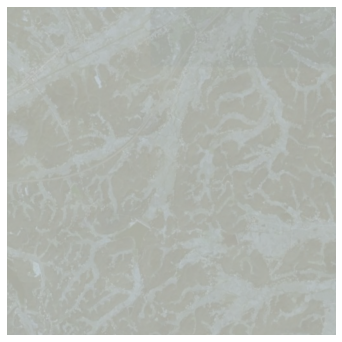

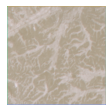

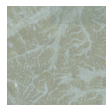

>Saved: plot_000650.png and model_000650.h5
>651, d1[0.000] d2[0.000] g[10.502] ssim[0.725] mse[0.024] psnr[16.251] avgssim[0.566] avgmse[0.028] avgpsnr[16.935]
>652, d1[0.000] d2[0.000] g[10.323] ssim[0.629] mse[0.019] psnr[17.225] avgssim[0.567] avgmse[0.028] avgpsnr[16.936]
>653, d1[0.000] d2[0.000] g[9.045] ssim[0.674] mse[0.016] psnr[17.952] avgssim[0.567] avgmse[0.028] avgpsnr[16.937]
>654, d1[0.000] d2[0.000] g[9.084] ssim[0.730] mse[0.015] psnr[18.114] avgssim[0.567] avgmse[0.028] avgpsnr[16.939]
>655, d1[0.000] d2[0.000] g[9.040] ssim[0.726] mse[0.016] psnr[17.936] avgssim[0.567] avgmse[0.028] avgpsnr[16.941]
>656, d1[0.000] d2[0.000] g[9.151] ssim[0.715] mse[0.014] psnr[18.428] avgssim[0.567] avgmse[0.028] avgpsnr[16.943]
>657, d1[0.000] d2[0.000] g[10.505] ssim[0.691] mse[0.023] psnr[16.461] avgssim[0.568] avgmse[0.028] avgpsnr[16.942]
>658, d1[0.000] d2[0.000] g[9.126] ssim[0.718] mse[0.019] psnr[17.187] avgssim[0.568] avgmse[0.028] avgpsnr[16.943]
>659, d1[0.000] d2[0.000]

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

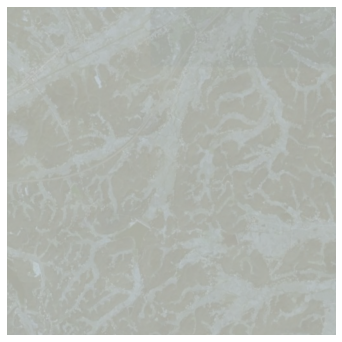

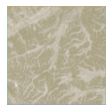

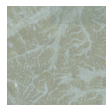

>Saved: plot_000700.png and model_000700.h5
>701, d1[0.000] d2[0.000] g[10.579] ssim[0.727] mse[0.023] psnr[16.409] avgssim[0.577] avgmse[0.027] avgpsnr[16.980]
>702, d1[0.000] d2[0.000] g[9.168] ssim[0.723] mse[0.018] psnr[17.523] avgssim[0.577] avgmse[0.027] avgpsnr[16.981]
>703, d1[0.000] d2[0.000] g[11.179] ssim[0.729] mse[0.013] psnr[18.729] avgssim[0.577] avgmse[0.027] avgpsnr[16.983]
>704, d1[0.000] d2[0.000] g[9.981] ssim[0.736] mse[0.022] psnr[16.639] avgssim[0.578] avgmse[0.027] avgpsnr[16.983]
>705, d1[0.000] d2[0.000] g[9.426] ssim[0.699] mse[0.018] psnr[17.498] avgssim[0.578] avgmse[0.027] avgpsnr[16.984]
>706, d1[0.000] d2[0.000] g[8.916] ssim[0.724] mse[0.016] psnr[18.077] avgssim[0.578] avgmse[0.027] avgpsnr[16.985]
>707, d1[0.000] d2[0.000] g[9.240] ssim[0.735] mse[0.018] psnr[17.556] avgssim[0.578] avgmse[0.027] avgpsnr[16.986]
>708, d1[0.000] d2[0.000] g[9.489] ssim[0.739] mse[0.014] psnr[18.573] avgssim[0.578] avgmse[0.027] avgpsnr[16.988]
>709, d1[0.000] d2[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

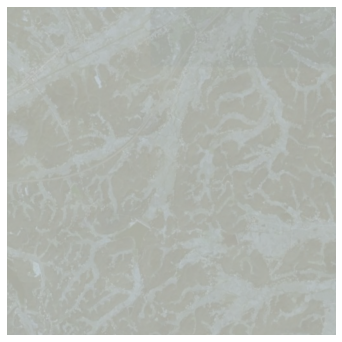

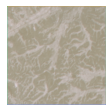

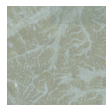

>Saved: plot_000750.png and model_000750.h5
>751, d1[0.000] d2[0.000] g[10.541] ssim[0.740] mse[0.014] psnr[18.642] avgssim[0.587] avgmse[0.026] avgpsnr[17.020]
>752, d1[0.000] d2[0.000] g[10.528] ssim[0.734] mse[0.024] psnr[16.252] avgssim[0.587] avgmse[0.026] avgpsnr[17.018]
>753, d1[0.000] d2[0.000] g[9.587] ssim[0.719] mse[0.020] psnr[16.998] avgssim[0.587] avgmse[0.026] avgpsnr[17.018]
>754, d1[0.000] d2[0.000] g[9.976] ssim[0.733] mse[0.015] psnr[18.135] avgssim[0.587] avgmse[0.026] avgpsnr[17.020]
>755, d1[0.000] d2[0.000] g[10.336] ssim[0.735] mse[0.023] psnr[16.375] avgssim[0.588] avgmse[0.026] avgpsnr[17.019]
>756, d1[0.000] d2[0.000] g[9.342] ssim[0.723] mse[0.019] psnr[17.295] avgssim[0.588] avgmse[0.026] avgpsnr[17.019]
>757, d1[0.000] d2[0.000] g[10.195] ssim[0.736] mse[0.014] psnr[18.432] avgssim[0.588] avgmse[0.026] avgpsnr[17.021]
>758, d1[0.000] d2[0.000] g[10.510] ssim[0.732] mse[0.023] psnr[16.302] avgssim[0.588] avgmse[0.026] avgpsnr[17.020]
>759, d1[0.000] d2[0.00

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

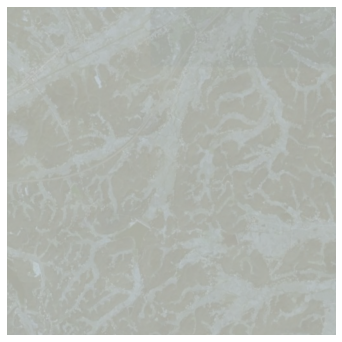

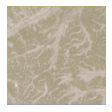

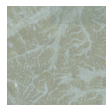

>Saved: plot_000800.png and model_000800.h5
>801, d1[0.000] d2[0.000] g[9.319] ssim[0.730] mse[0.019] psnr[17.299] avgssim[0.596] avgmse[0.026] avgpsnr[17.038]
>802, d1[0.000] d2[0.000] g[9.845] ssim[0.745] mse[0.014] psnr[18.388] avgssim[0.596] avgmse[0.026] avgpsnr[17.040]
>803, d1[0.000] d2[0.000] g[10.039] ssim[0.738] mse[0.022] psnr[16.649] avgssim[0.596] avgmse[0.026] avgpsnr[17.039]
>804, d1[0.000] d2[0.000] g[9.340] ssim[0.730] mse[0.019] psnr[17.279] avgssim[0.597] avgmse[0.026] avgpsnr[17.040]
>805, d1[0.000] d2[0.000] g[9.811] ssim[0.745] mse[0.015] psnr[18.371] avgssim[0.597] avgmse[0.026] avgpsnr[17.041]
>806, d1[0.000] d2[0.000] g[10.013] ssim[0.739] mse[0.022] psnr[16.670] avgssim[0.597] avgmse[0.026] avgpsnr[17.041]
>807, d1[0.000] d2[0.000] g[9.316] ssim[0.731] mse[0.019] psnr[17.305] avgssim[0.597] avgmse[0.026] avgpsnr[17.041]
>808, d1[0.000] d2[0.000] g[9.813] ssim[0.745] mse[0.014] psnr[18.395] avgssim[0.597] avgmse[0.026] avgpsnr[17.043]
>809, d1[0.000] d2[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

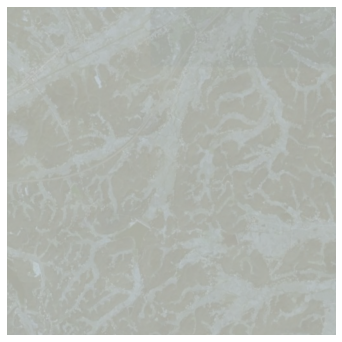

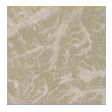

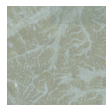

>Saved: plot_000850.png and model_000850.h5
>851, d1[0.000] d2[0.000] g[9.864] ssim[0.744] mse[0.021] psnr[16.826] avgssim[0.605] avgmse[0.025] avgpsnr[17.067]
>852, d1[0.000] d2[0.000] g[9.229] ssim[0.738] mse[0.018] psnr[17.408] avgssim[0.605] avgmse[0.025] avgpsnr[17.067]
>853, d1[0.000] d2[0.000] g[9.667] ssim[0.753] mse[0.014] psnr[18.484] avgssim[0.605] avgmse[0.025] avgpsnr[17.069]
>854, d1[0.000] d2[0.000] g[9.850] ssim[0.744] mse[0.021] psnr[16.843] avgssim[0.605] avgmse[0.025] avgpsnr[17.068]
>855, d1[0.000] d2[0.000] g[9.217] ssim[0.738] mse[0.018] psnr[17.426] avgssim[0.605] avgmse[0.025] avgpsnr[17.069]
>856, d1[0.000] d2[0.000] g[9.676] ssim[0.753] mse[0.014] psnr[18.496] avgssim[0.605] avgmse[0.025] avgpsnr[17.070]
>857, d1[0.000] d2[0.000] g[9.853] ssim[0.744] mse[0.021] psnr[16.841] avgssim[0.605] avgmse[0.025] avgpsnr[17.070]
>858, d1[0.000] d2[0.000] g[9.226] ssim[0.739] mse[0.018] psnr[17.414] avgssim[0.606] avgmse[0.025] avgpsnr[17.071]
>859, d1[0.000] d2[0.000] g[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

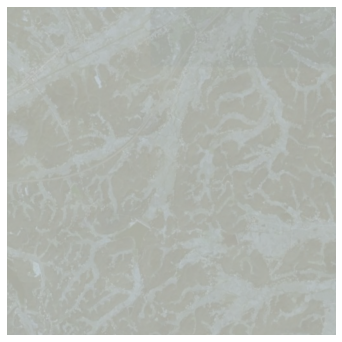

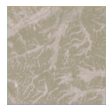

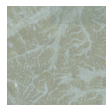

>Saved: plot_000900.png and model_000900.h5
>901, d1[0.000] d2[0.000] g[9.630] ssim[0.760] mse[0.014] psnr[18.551] avgssim[0.612] avgmse[0.025] avgpsnr[17.098]
>902, d1[0.000] d2[0.000] g[9.822] ssim[0.750] mse[0.020] psnr[16.917] avgssim[0.613] avgmse[0.025] avgpsnr[17.098]
>903, d1[0.000] d2[0.000] g[9.195] ssim[0.743] mse[0.018] psnr[17.508] avgssim[0.613] avgmse[0.025] avgpsnr[17.098]
>904, d1[0.000] d2[0.000] g[9.633] ssim[0.760] mse[0.014] psnr[18.564] avgssim[0.613] avgmse[0.025] avgpsnr[17.100]
>905, d1[0.000] d2[0.000] g[9.824] ssim[0.751] mse[0.020] psnr[16.916] avgssim[0.613] avgmse[0.025] avgpsnr[17.100]
>906, d1[0.000] d2[0.000] g[9.195] ssim[0.744] mse[0.018] psnr[17.511] avgssim[0.613] avgmse[0.025] avgpsnr[17.100]
>907, d1[0.000] d2[0.000] g[9.627] ssim[0.760] mse[0.014] psnr[18.565] avgssim[0.613] avgmse[0.025] avgpsnr[17.102]
>908, d1[0.000] d2[0.000] g[9.820] ssim[0.751] mse[0.020] psnr[16.928] avgssim[0.614] avgmse[0.025] avgpsnr[17.102]
>909, d1[0.000] d2[0.000] g[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

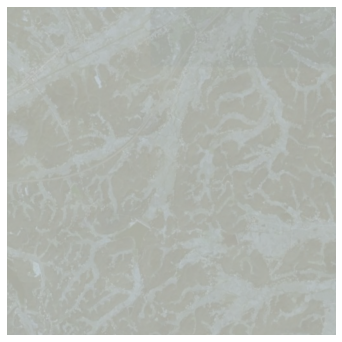

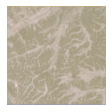

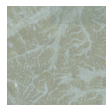

>Saved: plot_000950.png and model_000950.h5
>951, d1[0.000] d2[0.000] g[9.147] ssim[0.748] mse[0.017] psnr[17.610] avgssim[0.620] avgmse[0.025] avgpsnr[17.129]
>952, d1[0.000] d2[0.000] g[9.592] ssim[0.767] mse[0.014] psnr[18.653] avgssim[0.620] avgmse[0.025] avgpsnr[17.131]
>953, d1[0.000] d2[0.000] g[9.732] ssim[0.753] mse[0.020] psnr[17.066] avgssim[0.620] avgmse[0.025] avgpsnr[17.131]
>954, d1[0.000] d2[0.000] g[9.136] ssim[0.748] mse[0.017] psnr[17.626] avgssim[0.620] avgmse[0.025] avgpsnr[17.131]
>955, d1[0.000] d2[0.000] g[9.578] ssim[0.767] mse[0.014] psnr[18.667] avgssim[0.620] avgmse[0.025] avgpsnr[17.133]
>956, d1[0.000] d2[0.000] g[9.732] ssim[0.753] mse[0.020] psnr[17.067] avgssim[0.621] avgmse[0.025] avgpsnr[17.133]
>957, d1[0.000] d2[0.000] g[9.139] ssim[0.748] mse[0.017] psnr[17.625] avgssim[0.621] avgmse[0.025] avgpsnr[17.133]
>958, d1[0.000] d2[0.000] g[9.563] ssim[0.767] mse[0.014] psnr[18.663] avgssim[0.621] avgmse[0.025] avgpsnr[17.135]
>959, d1[0.000] d2[0.000] g[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

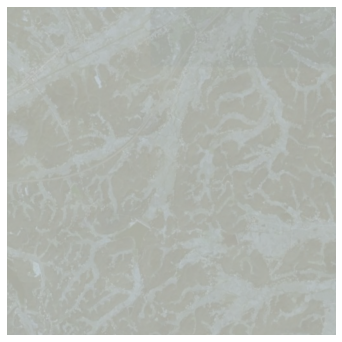

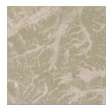

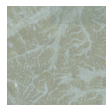

>Saved: plot_001000.png and model_001000.h5
>1001, d1[0.000] d2[0.000] g[9.719] ssim[0.755] mse[0.019] psnr[17.114] avgssim[0.627] avgmse[0.024] avgpsnr[17.163]
>1002, d1[0.000] d2[0.000] g[9.142] ssim[0.750] mse[0.017] psnr[17.672] avgssim[0.627] avgmse[0.024] avgpsnr[17.164]
>1003, d1[0.000] d2[0.000] g[9.551] ssim[0.772] mse[0.013] psnr[18.698] avgssim[0.627] avgmse[0.024] avgpsnr[17.165]
>1004, d1[0.000] d2[0.000] g[9.734] ssim[0.754] mse[0.019] psnr[17.112] avgssim[0.627] avgmse[0.024] avgpsnr[17.165]
>1005, d1[0.000] d2[0.000] g[9.154] ssim[0.749] mse[0.017] psnr[17.662] avgssim[0.627] avgmse[0.024] avgpsnr[17.166]
>1006, d1[0.000] d2[0.000] g[9.551] ssim[0.772] mse[0.014] psnr[18.692] avgssim[0.627] avgmse[0.024] avgpsnr[17.167]
>1007, d1[0.000] d2[0.000] g[9.725] ssim[0.755] mse[0.019] psnr[17.117] avgssim[0.628] avgmse[0.024] avgpsnr[17.167]
>1008, d1[0.000] d2[0.000] g[9.148] ssim[0.749] mse[0.017] psnr[17.675] avgssim[0.628] avgmse[0.024] avgpsnr[17.168]
>1009, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

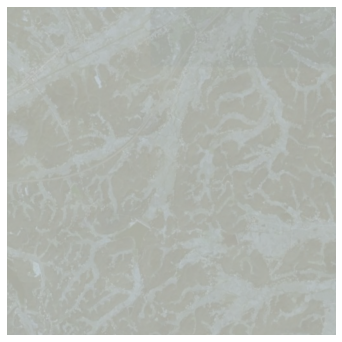

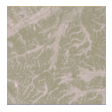

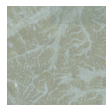

>Saved: plot_001050.png and model_001050.h5
>1051, d1[0.000] d2[0.000] g[9.523] ssim[0.772] mse[0.013] psnr[18.811] avgssim[0.633] avgmse[0.024] avgpsnr[17.197]
>1052, d1[0.000] d2[0.000] g[9.720] ssim[0.758] mse[0.019] psnr[17.193] avgssim[0.633] avgmse[0.024] avgpsnr[17.197]
>1053, d1[0.000] d2[0.000] g[9.102] ssim[0.750] mse[0.017] psnr[17.787] avgssim[0.633] avgmse[0.024] avgpsnr[17.197]
>1054, d1[0.000] d2[0.000] g[9.542] ssim[0.772] mse[0.013] psnr[18.838] avgssim[0.633] avgmse[0.024] avgpsnr[17.199]
>1055, d1[0.000] d2[0.000] g[9.711] ssim[0.758] mse[0.019] psnr[17.189] avgssim[0.634] avgmse[0.024] avgpsnr[17.199]
>1056, d1[0.000] d2[0.000] g[9.106] ssim[0.750] mse[0.017] psnr[17.771] avgssim[0.634] avgmse[0.024] avgpsnr[17.199]
>1057, d1[0.000] d2[0.000] g[9.507] ssim[0.772] mse[0.013] psnr[18.817] avgssim[0.634] avgmse[0.024] avgpsnr[17.201]
>1058, d1[0.000] d2[0.000] g[9.698] ssim[0.758] mse[0.019] psnr[17.205] avgssim[0.634] avgmse[0.024] avgpsnr[17.201]
>1059, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

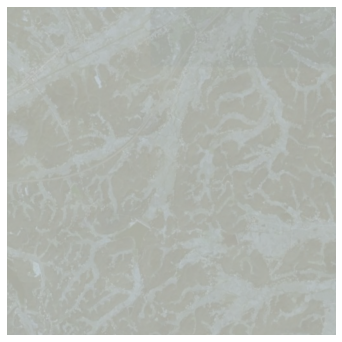

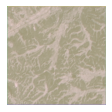

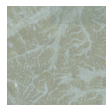

>Saved: plot_001100.png and model_001100.h5
>1101, d1[0.000] d2[0.000] g[9.059] ssim[0.750] mse[0.016] psnr[17.853] avgssim[0.639] avgmse[0.023] avgpsnr[17.232]
>1102, d1[0.000] d2[0.000] g[9.395] ssim[0.775] mse[0.013] psnr[18.866] avgssim[0.639] avgmse[0.023] avgpsnr[17.233]
>1103, d1[0.000] d2[0.000] g[9.619] ssim[0.758] mse[0.019] psnr[17.306] avgssim[0.639] avgmse[0.023] avgpsnr[17.233]
>1104, d1[0.000] d2[0.000] g[9.049] ssim[0.751] mse[0.016] psnr[17.873] avgssim[0.639] avgmse[0.023] avgpsnr[17.234]
>1105, d1[0.000] d2[0.000] g[9.410] ssim[0.776] mse[0.013] psnr[18.877] avgssim[0.639] avgmse[0.023] avgpsnr[17.235]
>1106, d1[0.000] d2[0.000] g[9.635] ssim[0.758] mse[0.019] psnr[17.294] avgssim[0.639] avgmse[0.023] avgpsnr[17.236]
>1107, d1[0.000] d2[0.000] g[9.068] ssim[0.751] mse[0.016] psnr[17.849] avgssim[0.640] avgmse[0.023] avgpsnr[17.236]
>1108, d1[0.000] d2[0.000] g[9.404] ssim[0.776] mse[0.013] psnr[18.854] avgssim[0.640] avgmse[0.023] avgpsnr[17.238]
>1109, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

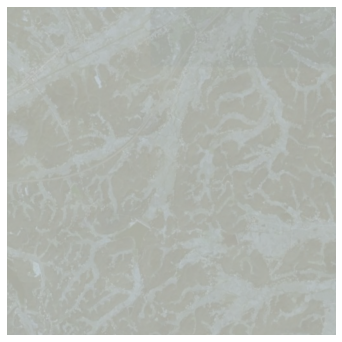

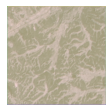

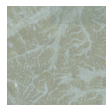

>Saved: plot_001150.png and model_001150.h5
>1151, d1[0.000] d2[0.000] g[9.630] ssim[0.756] mse[0.018] psnr[17.346] avgssim[0.644] avgmse[0.023] avgpsnr[17.266]
>1152, d1[0.000] d2[0.000] g[9.114] ssim[0.750] mse[0.016] psnr[17.883] avgssim[0.644] avgmse[0.023] avgpsnr[17.266]
>1153, d1[0.000] d2[0.000] g[9.401] ssim[0.782] mse[0.013] psnr[18.814] avgssim[0.644] avgmse[0.023] avgpsnr[17.267]
>1154, d1[0.000] d2[0.000] g[9.629] ssim[0.755] mse[0.018] psnr[17.352] avgssim[0.645] avgmse[0.023] avgpsnr[17.268]
>1155, d1[0.000] d2[0.000] g[9.120] ssim[0.750] mse[0.016] psnr[17.881] avgssim[0.645] avgmse[0.023] avgpsnr[17.268]
>1156, d1[0.000] d2[0.000] g[9.402] ssim[0.783] mse[0.013] psnr[18.806] avgssim[0.645] avgmse[0.023] avgpsnr[17.269]
>1157, d1[0.000] d2[0.000] g[9.637] ssim[0.755] mse[0.018] psnr[17.351] avgssim[0.645] avgmse[0.023] avgpsnr[17.269]
>1158, d1[0.000] d2[0.000] g[9.127] ssim[0.750] mse[0.016] psnr[17.881] avgssim[0.645] avgmse[0.023] avgpsnr[17.270]
>1159, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

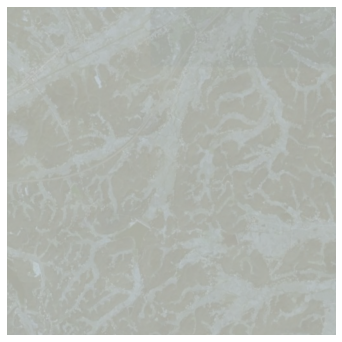

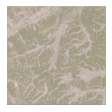

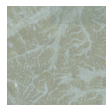

>Saved: plot_001200.png and model_001200.h5
>1201, d1[0.000] d2[0.000] g[9.438] ssim[0.785] mse[0.013] psnr[18.780] avgssim[0.649] avgmse[0.023] avgpsnr[17.297]
>1202, d1[0.000] d2[0.000] g[9.669] ssim[0.754] mse[0.018] psnr[17.386] avgssim[0.649] avgmse[0.023] avgpsnr[17.297]
>1203, d1[0.000] d2[0.000] g[9.178] ssim[0.749] mse[0.016] psnr[17.924] avgssim[0.649] avgmse[0.023] avgpsnr[17.298]
>1204, d1[0.000] d2[0.000] g[9.439] ssim[0.785] mse[0.013] psnr[18.786] avgssim[0.649] avgmse[0.023] avgpsnr[17.299]
>1205, d1[0.000] d2[0.000] g[9.674] ssim[0.754] mse[0.018] psnr[17.382] avgssim[0.650] avgmse[0.023] avgpsnr[17.299]
>1206, d1[0.000] d2[0.000] g[9.180] ssim[0.749] mse[0.016] psnr[17.923] avgssim[0.650] avgmse[0.023] avgpsnr[17.300]
>1207, d1[0.000] d2[0.000] g[9.435] ssim[0.785] mse[0.013] psnr[18.788] avgssim[0.650] avgmse[0.023] avgpsnr[17.301]
>1208, d1[0.000] d2[0.000] g[9.674] ssim[0.754] mse[0.018] psnr[17.384] avgssim[0.650] avgmse[0.023] avgpsnr[17.301]
>1209, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

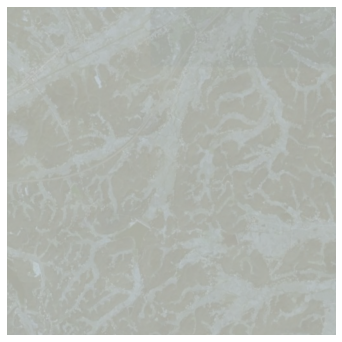

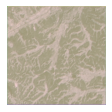

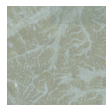

>Saved: plot_001250.png and model_001250.h5
>1251, d1[0.000] d2[0.000] g[9.135] ssim[0.748] mse[0.016] psnr[18.033] avgssim[0.654] avgmse[0.023] avgpsnr[17.327]
>1252, d1[0.000] d2[0.000] g[9.360] ssim[0.788] mse[0.013] psnr[18.853] avgssim[0.654] avgmse[0.023] avgpsnr[17.328]
>1253, d1[0.000] d2[0.000] g[9.600] ssim[0.752] mse[0.018] psnr[17.505] avgssim[0.654] avgmse[0.023] avgpsnr[17.329]
>1254, d1[0.000] d2[0.000] g[9.130] ssim[0.748] mse[0.016] psnr[18.043] avgssim[0.654] avgmse[0.023] avgpsnr[17.329]
>1255, d1[0.000] d2[0.000] g[9.365] ssim[0.789] mse[0.013] psnr[18.860] avgssim[0.654] avgmse[0.023] avgpsnr[17.330]
>1256, d1[0.000] d2[0.000] g[9.609] ssim[0.751] mse[0.018] psnr[17.506] avgssim[0.654] avgmse[0.023] avgpsnr[17.331]
>1257, d1[0.000] d2[0.000] g[9.134] ssim[0.747] mse[0.016] psnr[18.045] avgssim[0.654] avgmse[0.023] avgpsnr[17.331]
>1258, d1[0.000] d2[0.000] g[9.371] ssim[0.788] mse[0.013] psnr[18.867] avgssim[0.654] avgmse[0.023] avgpsnr[17.332]
>1259, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

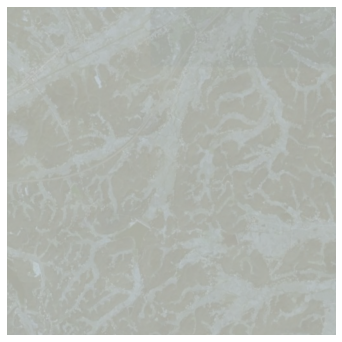

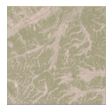

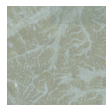

>Saved: plot_001300.png and model_001300.h5
>1301, d1[0.000] d2[0.000] g[9.563] ssim[0.751] mse[0.017] psnr[17.573] avgssim[0.658] avgmse[0.022] avgpsnr[17.359]
>1302, d1[0.000] d2[0.000] g[9.123] ssim[0.747] mse[0.015] psnr[18.114] avgssim[0.658] avgmse[0.022] avgpsnr[17.360]
>1303, d1[0.000] d2[0.000] g[9.302] ssim[0.791] mse[0.013] psnr[18.869] avgssim[0.658] avgmse[0.022] avgpsnr[17.361]
>1304, d1[0.000] d2[0.000] g[9.547] ssim[0.751] mse[0.017] psnr[17.589] avgssim[0.658] avgmse[0.022] avgpsnr[17.361]
>1305, d1[0.000] d2[0.000] g[9.121] ssim[0.747] mse[0.015] psnr[18.127] avgssim[0.658] avgmse[0.022] avgpsnr[17.362]
>1306, d1[0.000] d2[0.000] g[9.289] ssim[0.791] mse[0.013] psnr[18.865] avgssim[0.658] avgmse[0.022] avgpsnr[17.363]
>1307, d1[0.000] d2[0.000] g[9.534] ssim[0.750] mse[0.017] psnr[17.609] avgssim[0.658] avgmse[0.022] avgpsnr[17.363]
>1308, d1[0.000] d2[0.000] g[9.115] ssim[0.746] mse[0.015] psnr[18.141] avgssim[0.658] avgmse[0.022] avgpsnr[17.363]
>1309, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

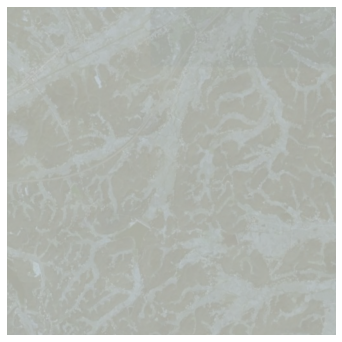

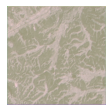

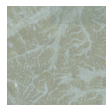

>Saved: plot_001350.png and model_001350.h5
>1351, d1[0.000] d2[0.000] g[9.281] ssim[0.793] mse[0.013] psnr[18.838] avgssim[0.662] avgmse[0.022] avgpsnr[17.391]
>1352, d1[0.000] d2[0.000] g[9.514] ssim[0.747] mse[0.017] psnr[17.678] avgssim[0.662] avgmse[0.022] avgpsnr[17.392]
>1353, d1[0.000] d2[0.000] g[9.146] ssim[0.744] mse[0.015] psnr[18.210] avgssim[0.662] avgmse[0.022] avgpsnr[17.392]
>1354, d1[0.000] d2[0.000] g[9.283] ssim[0.793] mse[0.013] psnr[18.835] avgssim[0.662] avgmse[0.022] avgpsnr[17.393]
>1355, d1[0.000] d2[0.000] g[9.519] ssim[0.747] mse[0.017] psnr[17.678] avgssim[0.662] avgmse[0.022] avgpsnr[17.393]
>1356, d1[0.000] d2[0.000] g[9.152] ssim[0.744] mse[0.015] psnr[18.211] avgssim[0.662] avgmse[0.022] avgpsnr[17.394]
>1357, d1[0.000] d2[0.000] g[9.283] ssim[0.793] mse[0.013] psnr[18.836] avgssim[0.662] avgmse[0.022] avgpsnr[17.395]
>1358, d1[0.000] d2[0.000] g[9.510] ssim[0.748] mse[0.017] psnr[17.686] avgssim[0.662] avgmse[0.022] avgpsnr[17.395]
>1359, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

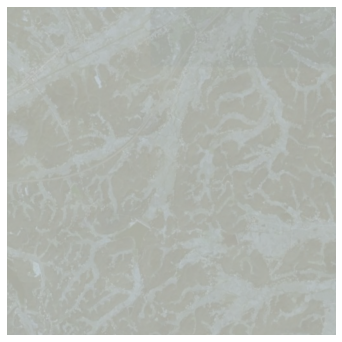

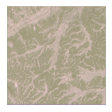

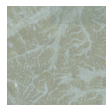

>Saved: plot_001400.png and model_001400.h5
>1401, d1[0.000] d2[0.000] g[9.319] ssim[0.739] mse[0.015] psnr[18.105] avgssim[0.665] avgmse[0.022] avgpsnr[17.419]
>1402, d1[0.000] d2[0.000] g[9.442] ssim[0.787] mse[0.013] psnr[18.732] avgssim[0.665] avgmse[0.022] avgpsnr[17.420]
>1403, d1[0.000] d2[0.000] g[9.748] ssim[0.746] mse[0.018] psnr[17.491] avgssim[0.665] avgmse[0.022] avgpsnr[17.420]
>1404, d1[0.000] d2[0.000] g[9.326] ssim[0.738] mse[0.015] psnr[18.108] avgssim[0.665] avgmse[0.022] avgpsnr[17.421]
>1405, d1[0.000] d2[0.000] g[9.448] ssim[0.786] mse[0.013] psnr[18.741] avgssim[0.666] avgmse[0.022] avgpsnr[17.422]
>1406, d1[0.000] d2[0.000] g[9.755] ssim[0.746] mse[0.018] psnr[17.492] avgssim[0.666] avgmse[0.022] avgpsnr[17.422]
>1407, d1[0.000] d2[0.000] g[9.327] ssim[0.738] mse[0.015] psnr[18.109] avgssim[0.666] avgmse[0.022] avgpsnr[17.422]
>1408, d1[0.000] d2[0.000] g[9.447] ssim[0.786] mse[0.013] psnr[18.749] avgssim[0.666] avgmse[0.022] avgpsnr[17.423]
>1409, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

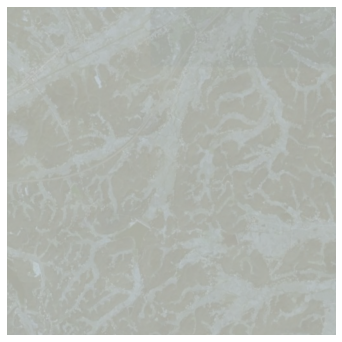

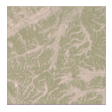

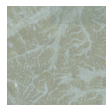

>Saved: plot_001450.png and model_001450.h5
>1451, d1[0.000] d2[0.000] g[9.908] ssim[0.751] mse[0.019] psnr[17.318] avgssim[0.668] avgmse[0.022] avgpsnr[17.442]
>1452, d1[0.000] d2[0.000] g[9.305] ssim[0.738] mse[0.016] psnr[18.002] avgssim[0.668] avgmse[0.022] avgpsnr[17.442]
>1453, d1[0.000] d2[0.000] g[9.552] ssim[0.772] mse[0.013] psnr[18.970] avgssim[0.668] avgmse[0.022] avgpsnr[17.443]
>1454, d1[0.000] d2[0.000] g[9.872] ssim[0.751] mse[0.018] psnr[17.352] avgssim[0.669] avgmse[0.022] avgpsnr[17.443]
>1455, d1[0.000] d2[0.000] g[9.287] ssim[0.738] mse[0.016] psnr[18.020] avgssim[0.669] avgmse[0.022] avgpsnr[17.444]
>1456, d1[0.000] d2[0.000] g[9.535] ssim[0.773] mse[0.013] psnr[18.971] avgssim[0.669] avgmse[0.022] avgpsnr[17.445]
>1457, d1[0.000] d2[0.000] g[9.852] ssim[0.750] mse[0.018] psnr[17.376] avgssim[0.669] avgmse[0.022] avgpsnr[17.445]
>1458, d1[0.000] d2[0.000] g[9.271] ssim[0.737] mse[0.016] psnr[18.041] avgssim[0.669] avgmse[0.022] avgpsnr[17.445]
>1459, d1[0.000] d2[

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

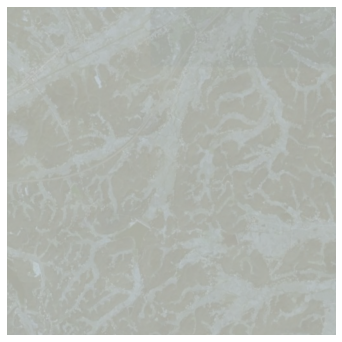

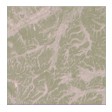

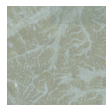

>Saved: plot_001500.png and model_001500.h5


In [44]:
dataset = tf_dataset(tg,tm,1)
print("Dataset loaded")
print(dataset)
#image_shape = 
image_shape = (512,512,3)
d_model = discriminator(image_shape)

g_model = Spa_gen(image_shape)


gan_model = call_GAN(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, dataset, n_epochs=1500)

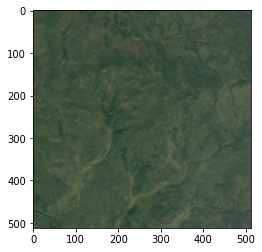

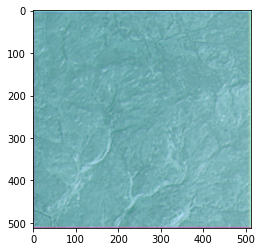

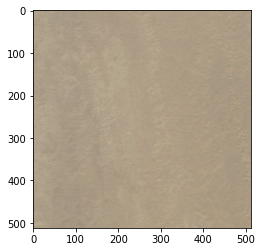

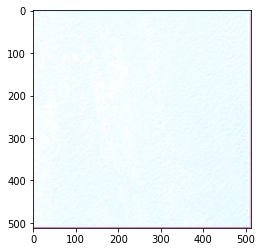

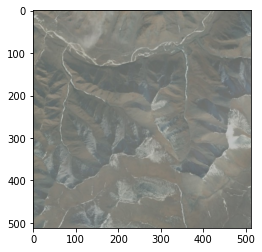

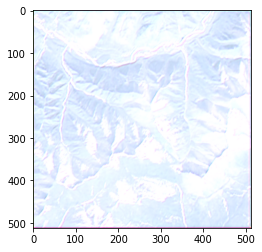

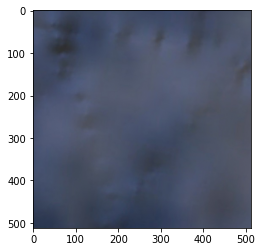

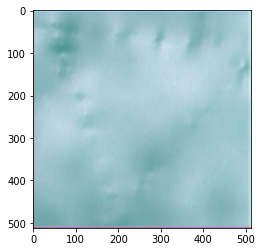

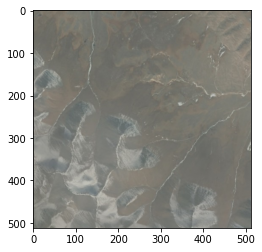

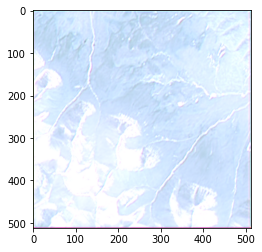

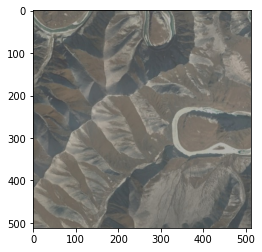

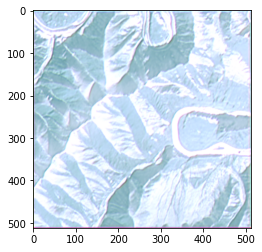

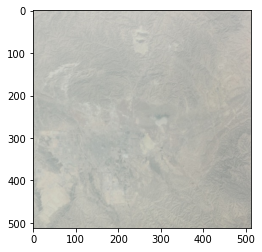

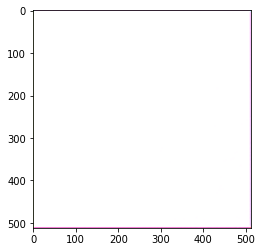

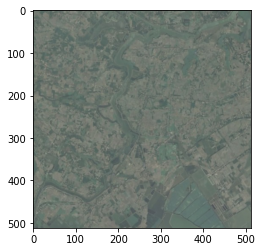

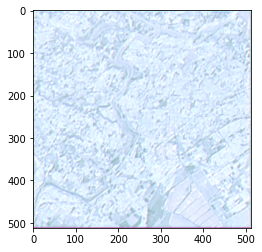

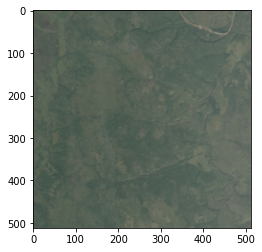

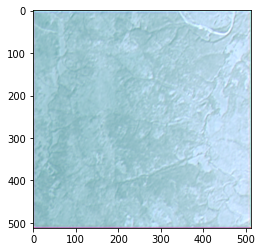

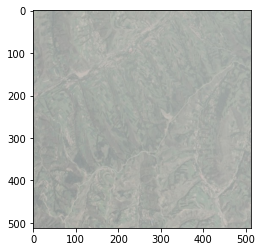

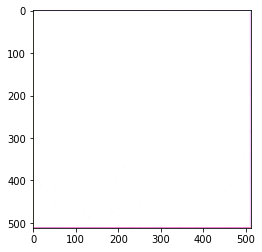

In [49]:
cloudypath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/cloudy_image/'
testcd = [os.path.join(cloudypath,x) for x in trainlist]
for i in testcd[60:70]:
    im = cv2.imread(i)
    imm = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    imm = imm/255
    plt.imshow(imm)
    plt.show()
    im1 = imm[np.newaxis, :, :, :]
    ts = g_model.predict(im1)
    ts = np.squeeze(ts)
    rs = cv2.cvtColor(ts, cv2.COLOR_RGB2BGR)
    #rs = rs/255
    #print(rs)
    #ts = ts.astype('uint8')
    rs = rs+1/2
    plt.imshow(rs)
    #plt.imshow(ts)
    plt.show()

In [ ]:
traincloud = tf.data.Dataset.from_tensor_slices(traincloud)

In [ ]:
im = cv2.imread(testcd[11])

im =(im+1)/2.0
im = im[np.newaxis, :, :, :]
ik = g_model.predict(im)
ik = ik.astype('uint16')
ti = np.squeeze(ik)
ti = cv2.cvtColor(ti, cv2.COLOR_BGR2RGB)
plt.imshow(ti)

In [50]:
[a,b], c = generate_real_samples(dataset, 1, 1)

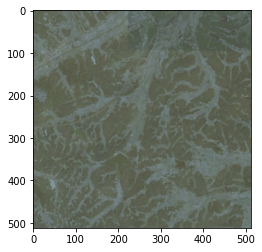

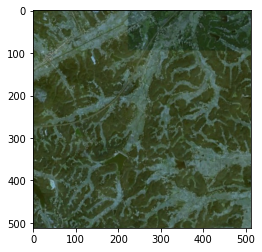

In [51]:
aa = tf.squeeze(a)
bb = tf.squeeze(b)
plt.imshow(aa)
plt.show()
plt.imshow(bb)
plt.show()

In [52]:
ff, gg = generate_fake_samples(g_model, a, 1)


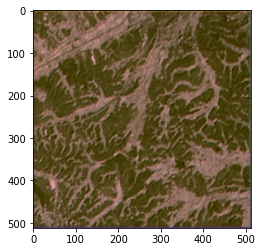

In [54]:
fff = tf.squeeze(ff)

plt.imshow( fff)

In [ ]:
ssim3 = tf.image.ssim(bb, fff, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
loss = tf.keras.losses.mean_squared_error(bb, fff)
psnr2 = tf.image.psnr(bb, fff, max_val=1.0)

In [ ]:
print(ssim3)
print(loss)
print(psnr2)

In [ ]:
l =tf.math.reduce_mean(
    loss, axis=None, keepdims=False, name=None
)

In [ ]:
l

In [ ]:
o = testcd[20]
oc = cv2.imread(str(o)).astype('float32')
occ = oc[np.newaxis, :, :, :]
        
ock = occ/255
ock.shape

In [ ]:
cldy = tf.convert_to_tensor(ock)
cldy

In [ ]:
rt = g_model.predict(cldy)

In [ ]:
rtt = np.squeeze(rt)
plt.imshow(rtt, cmap = 'hot')

In [ ]:
def test(testdataloader, gen, cmse, epoch):
    avgmse = 0
    avgpsnr = 0
    avgssim = 0
    
    x = batch[0]
    t = batch[1]
    
    
    out = gen
    mse = cmse(out)
    psnr = 10 * np.log10(1 / mse.item())
    
    img1 = np.tensordot(out.transpose(1,2,0), [0.298912, 0.586611, 0.114478], axes =1)
    img2 = np.tensordot(t.transpose(1,2,0), [0.298912, 0.586611, 0.114478], axes =1)
    
    ssim = SSIM(img1, img2)
    avg_mse += mse.item()
    avg_psnr += psnr
    avg_ssim += ssim
    avg_mse = avg_mse / len(testdataloader)
    avg_psnr = avg_psnr / len(testdataloader)
    avg_ssim = avg_ssim / len(testdataloader)
    
    print("===> Avg. MSE: {:.4f}".format(avg_mse))
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr))
    print("===> Avg. SSIM: {:.4f} dB".format(avg_ssim))
    
    log_test = {}
    log_test['epoch'] = epoch
    log_test['mse'] = avg_mse
    log_test['psnr'] = avg_psnr
    log_test['ssim'] = avg_ssim
    
    return log_test

In [ ]:
def save_image(opdir, x, num, epoch, filename = None):
    test_dir = os.path.join(out_dir, 'epoch_{0.04d}'.format(epoch))
    if filename is not None:
        test_path = os.path.join(test_dir, filename)
    else:
        test_path = os.path.join(test_dir,'test_{0:04d}.png'.format(num) )
    
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    cv2.imwrite(test_path, x)

In [ ]:
def heatmap(img):
    if len(img.shape)==3:
        b.h.w = img.shape
        heat = np.zeros((b,3, h,w)).astype('unit8')
        for i in range(b):
            heat[i,:,:,:] = np.transpose(cv2.applyColorMap(img[i,:,:],cv2.COLORMAP_JET),(2,0,1))
    else:
        b,c,h,w = img.shape
        heat = np.zeros((b,3,h,w)).astype('uint8')
        for i in range(b):
            heat[i,:,:,:] = np.transpose(cv2.applyColorMap(img[i,0,:,:],cv2.COLORMAP_JET),(2,0,1))
    return heat

In [ ]:
def saveattasheatmap(filename,att):
    att_heat = heatmap(att)
    cv2.imwrite(filename, att_heat)
    print(filename, 'saved')

In [ ]:
def tf_dataset(x,y, batchs):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(datapreprocesstest)
    dataset = dataset.batch(batchs)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
def datapreprocesstest(c,g):
    tc = []
    tg = []
    fc = glob.glob(c)
    fg = glob.glob(g)
    for f1 in fc:
        Im =cv2.imread(str(c)).astype(np.float32)
        tc.append(Im)
    for f2 in fg:
        Ig = cv2.imread(str(g)).astype(np.float32)
        tg.append(Ig)    
    tc = tc/255
    tg = tg/255
    tc = tc.transpose(2,0,1)
    tg = tg.transpose(2,0,1)
    
    return tc, tg

In [ ]:
def datapreprocesstrain(c):
    trc = cv2.imread(c).astype(np.float32)
    trc = trc/255
    trc = trc.transpose(2,0,1)
    return trc